In [11]:
import hydromt
import pandas as pd
from hydromt import DataCatalog
from hydromt_sfincs import SfincsModel
import datetime
import xarray as xr
import sys, os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('./eva_script')

from eva_script import eva #This contains all the functions  you need
#See the description of all the functions here: https://github.com/Deltares/hydromt/blob/eva/hydromt/stats/eva.py 

#from eva import eva_block_maxima
#from eva import get_peak_hydrographs

In [12]:
#To export your BC timeseries from your SfincsModel
sfincs_root = 'sfincs_update_bangkok_wg_1981-2010b_variability_10' #Path to your model
mod = hydromt.SfincsModel(sfincs_root, mode='r') #Reading the model

(<Figure size 432x648 with 3 Axes>,
 array([<AxesSubplot:title={'center':'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>,
        <AxesSubplot:title={'center':'SFINCS discharge forcing (dis)'}, ylabel='discharge\n[m3.s-1]'>,
        <AxesSubplot:title={'center':'SFINCS precipitation forcing (precip)'}, ylabel='precipitation\n[mm.hr-1]'>],
       dtype=object))

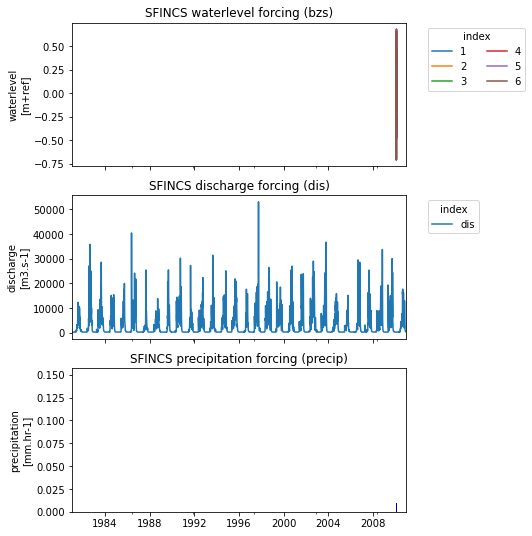

In [13]:
mod.plot_forcing()

In [14]:
#We export the timeseries
da_river = mod.forcing['dis'].copy() #Pick the boundary condition you want (e.g. bzs for coastal). To see all forcings, try mod.forcing
da_river.to_netcdf('P:/11206881-climate-risk-in-cities/msc_theses/Jasper/hydromt_sfincs-main/Case_studies/sfincs_update_bangkok_wg_1981-2010b_variability_10/boundary_conditions/discharge.nc') #Path to where you want to save the BC data


PermissionError: [Errno 13] Permission denied: b'P:\\11206881-climate-risk-in-cities\\msc_theses\\Jasper\\hydromt_sfincs-main\\Case_studies\\sfincs_update_bangkok_wg_1981-2010b_variability_10\\boundary_conditions\\discharge.nc'

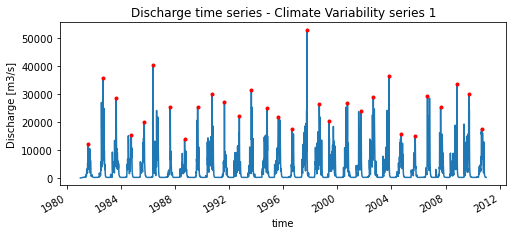

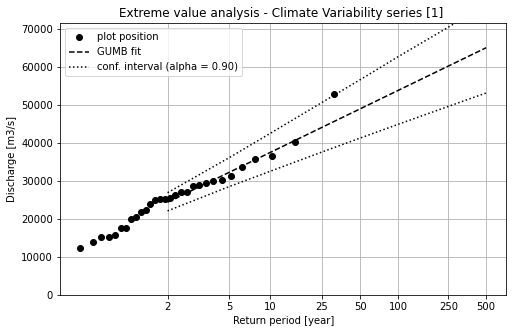

In [ ]:
#%% CREATING DESIGN EVENTS: In this case for discharge
figure_plotting = True #To show the figures and enter in the if functions

#Open your data
da_q = xr.open_dataarray('P:/11206881-climate-risk-in-cities/msc_theses/Jasper/hydromt_sfincs-main/Case_studies/sfincs_update_bangkok_wg_1981-2010b_variability_10/boundary_conditions/discharge.nc', chunks={"time": -1}).load() #Replace this with your dataset
#da_q = da_q.drop_sel({'index':[2,3]})
ds_bm = eva.eva_block_maxima(da_q, min_dist=14).load() #We extract the maxima over a certain period: by default a year. Peaks are independent if they are separated by at least 14 days

if figure_plotting == True:
    for i in np.arange(1, len(da_q.index.values)+1):
        fig, ax = plt.subplots(1,1, figsize=(8, 3))
        da_q.sel(index=i).plot()
        ds_bm['peaks'].sel(index=i).plot(marker='.', color='red', label='peaks')
        ax.set_ylabel('Discharge [m3/s]')
        ax.set_title(f'Discharge time series - Climate Variability series {i}')

    for i in np.arange(1, len(da_q.index.values)+1):
        da0 = ds_bm.sel(index=i)
        _, ax = plt.subplots(1, 1, figsize=(8, 5))
        _ = eva.plot_return_values(
            da0['peaks'].values,
            da0['parameters'].values,
            distribution=da0['distribution'].item(),
            extremes_rate=da0['extremes_rate'].item(),
            ax=ax
        )
        ax.set_ylabel('Discharge [m3/s]')
        ax.set_xlabel('Return period [year]')
        ax.set_title(f'Flow Frequency Curve - Climate Variability Series {[i]} ')

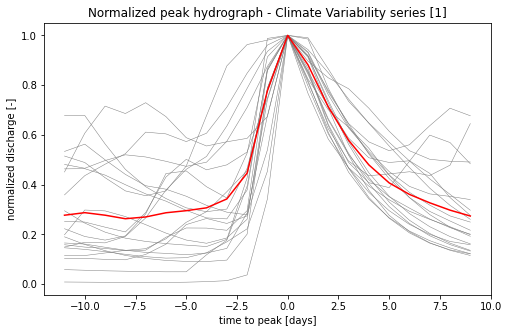

In [ ]:
#%% We extract the shape of the events for a given time window
da_hydrograph0 = eva.get_peak_hydrographs(
    da_q.chunk({'time':-1}), 
    ds_bm["peaks"].chunk({'time':-1}), 
    wdw_size=21,
    n_peaks=20,
)

da_hydrograph = da_hydrograph0.mean("peak")
da_hydrograph['time'].attrs.update(unit='days')

#da_hydrograph.expand_dims('index')
if figure_plotting == True:
    for i in np.arange(1, len(da_q.index.values)+1):
        fig, ax = plt.subplots(1,1, figsize=(8,5))
        
        da_hydrograph0.plot.line(x='time', color='gray', lw=0.5, add_legend=False) #.sel(index=i)
        da_hydrograph.plot.line(x='time', color='red', lw=1.5)
        ax.set_ylabel('normalized discharge [-]')
        ax.set_xlabel('time to peak [days]')
        ax.set_title(f'Normalized Peak Hydrograph - Climate Variability Series {[i]}')
        #plt.savefig(f'..', dpi=300, bbox_inches='tight') #To save your figure


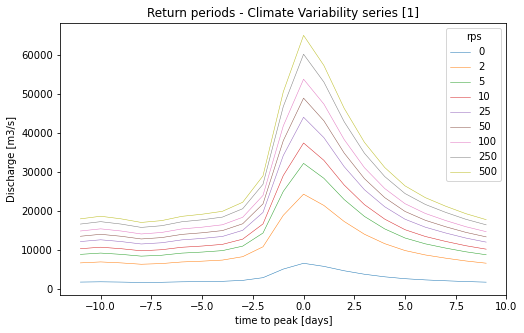

In [ ]:
#%% We do the Extreme Value Analysis anc combine with the shape of the hydrograph

#We calculate the mean discharge and save this >> depending on the variable you might want this or not!
da_q_rp0 = da_q.mean('time').expand_dims('rps')  #We calculate the  mean yearly value
da_q_rp0['rps'] = xr.IndexVariable('rps', [0])
da_q_rp0 = da_q_rp0.reset_coords(drop=True).compute()

da_q_rps = xr.concat([da_q_rp0/da_hydrograph.mean('time'), ds_bm['return_values']], dim='rps')

#We multiple the magnitude of the events (da_q_rps) with the shape of the hydrograph (from 0 to 1)  (da_hydrograph)
da_events = da_q_rps * da_hydrograph 
da_events.name = 'events'

#We save the results
da_events.to_netcdf('P:/11206881-climate-risk-in-cities/msc_theses/Jasper/hydromt_sfincs-main/Case_studies/sfincs_update_bangkok_wg_1981-2010b_variability_10/boundary_conditions/fluvial_design_events.nc')
da_events.close()

if figure_plotting == True:
    for i in np.arange(1, len(da_events.index.values)+1):
        fig, ax = plt.subplots(1,1, figsize=(8,5))
        da_events.sel(index=i).plot.line(x='time', lw=0.5)
        ax.set_ylabel('Discharge [m3/s]')
        ax.set_xlabel('time to peak [days]')
        ax.set_title(f'Return Periods - Climate Variability Series {[i]}')

In [ ]:
#da = da_q.plot()
da_q_c = xr.open_dataarray('P:/11206881-climate-risk-in-cities/msc_theses/Jasper/hydromt_sfincs-main/Case_studies/sfincs_update_bangkok_wg_1981-2010b_climx_1/boundary_conditions/discharge.nc', chunks={"time": -1}).load()
ds = da_q.rolling(time=5).mean().max() #historic
da = da_q_c.rolling(time=5).mean().max() #climate
print(da_q.rolling(time=5).mean().max())
print(da_q_c.rolling(time=5).mean().max())

<xarray.DataArray 'dis' ()>
array(43039.38)
Coordinates:
    spatial_ref  int32 1
<xarray.DataArray 'dis' ()>
array(32674.658)
Coordinates:
    spatial_ref  int32 1


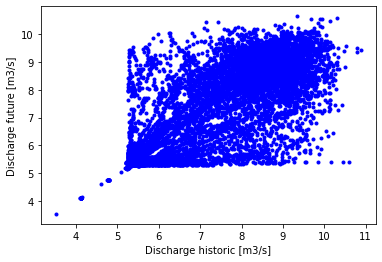

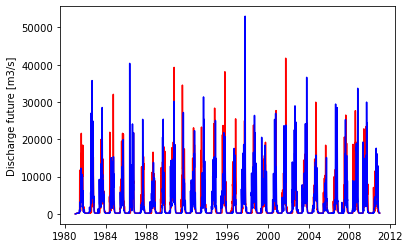

In [ ]:
q_his = da_q.sel(index=1).to_series()
q_future = da_q_c.sel(index=1).to_series()

diff = np.log(q_his) - np.log(q_future)
#diff = (q_his) - (q_future)
#diff.plot()

import matplotlib.pyplot as plt

f, ax =plt.subplots()
ax.plot(np.log(q_his), np.log(q_future), '.b')
#ax.plot((q_his), (q_future), '.b')
#ax.plot([0,60000], [0,60000], '-k')
ax.set_xlabel('Discharge historic [m3/s]')
ax.set_ylabel('Discharge future [m3/s]')
plt.show()
#f.savefig(r'...')

f, ax =plt.subplots()
ax.plot(q_future.index, q_future, '-r') #lw, marker, ms, alpha,...order
ax.plot(q_his.index, q_his, '-b') #lw, marker, ms, alpha,...
ax.set_ylabel('Discharge future [m3/s]')
plt.show()
